# Analyzing Customer Churn at a Bank 

### By Danika Hannon - 10/20/2019

The prompt for this challenge is: a company wants to segment its customers.

Next Steps:

1. Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.
2. Explore the data and spend a lot of time going over its quirks. You should understand how it was gathered, what's in it, and what the variables look like.
3. You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

### Import Statements

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from itertools import cycle

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### 1. The Dataframe

Because I work in fintech, I'm going to analyze a dataset about bank customers that I found on Kaggle. For your reference, here's a link to the [dataset](https://www.kaggle.com/santoshd3/bank-customers/).

In [4]:
churn_df = pd.read_csv('Churn Modeling.csv')

### 2. Exploratory Data Analysis (EDA)

_Editing the Dataframe_

To get started, I'm going to look at the variables to see if any of them could be dropped or need to be changed (like changing a categorical variable into a number).

In [5]:
churn_df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


I'm going to drop "RowNumber" because that column's redundant.

And I'll drop "Surname" because there are so many unique values that I'm concerned it'd use too many resources to analyze.

In [6]:
dropped_col_df = churn_df[['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
                           'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [7]:
dropped_col_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CustomerId         10000 non-null int64
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


I'll use "getdummies" to transform the categorical values into numbers so that it'll be easier to work with the variables later on.

In [8]:
categorical_df = dropped_col_df[['EstimatedSalary', 'Exited']]

categorical_df.head(5)

,EstimatedSalary,Exited
0,101348.88,1
1,112542.58,0
2,113931.57,1
3,93826.63,0
4,79084.10,0


In [9]:
categorical_cols = ['Geography']

for col in categorical_cols:
    df_dummies = pd.get_dummies(dropped_col_df[col], prefix=col)
    categorical_df = categorical_df.merge(
        df_dummies, left_index=True, right_index=True, suffixes=('_left', '_right'))

categorical_df.head()

,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,101348.88,1,1,0,0
1,112542.58,0,0,0,1
2,113931.57,1,1,0,0
3,93826.63,0,1,0,0
4,79084.10,0,0,0,1


In [10]:
all_variables_df = categorical_df.merge(churn_df[['CustomerId', 'CreditScore', 'Gender', 'Age', 
                                                  'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                                                  'EstimatedSalary', 'Exited']])

print(all_variables_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 14 columns):
EstimatedSalary      10002 non-null float64
Exited               10002 non-null int64
Geography_France     10002 non-null uint8
Geography_Germany    10002 non-null uint8
Geography_Spain      10002 non-null uint8
CustomerId           10002 non-null int64
CreditScore          10002 non-null int64
Gender               10002 non-null object
Age                  10002 non-null int64
Tenure               10002 non-null int64
Balance              10002 non-null float64
NumOfProducts        10002 non-null int64
HasCrCard            10002 non-null int64
IsActiveMember       10002 non-null int64
dtypes: float64(2), int64(8), object(1), uint8(3)
memory usage: 967.0+ KB
None


In [11]:
all_variables_df['Gender'] = pd.get_dummies(all_variables_df['Gender'], drop_first=True)

I'll double-check the values for "Gender" in each dataframe to make sure that get_dummies worked.

In [12]:
dropped_col_df['Gender'].head(10)

0    Female
1    Female
2    Female
3    Female
4    Female
5      Male
6      Male
7    Female
8      Male
9      Male
Name: Gender, dtype: object

In [13]:
all_variables_df['Gender'].head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    0
8    1
9    1
Name: Gender, dtype: uint8

I'm also going to look at the columns in the original dataframe and the current one to make sure that nothing got lost during the changes.

In [14]:
dropped_col_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CustomerId         10000 non-null int64
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [15]:
all_variables_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 14 columns):
EstimatedSalary      10002 non-null float64
Exited               10002 non-null int64
Geography_France     10002 non-null uint8
Geography_Germany    10002 non-null uint8
Geography_Spain      10002 non-null uint8
CustomerId           10002 non-null int64
CreditScore          10002 non-null int64
Gender               10002 non-null uint8
Age                  10002 non-null int64
Tenure               10002 non-null int64
Balance              10002 non-null float64
NumOfProducts        10002 non-null int64
HasCrCard            10002 non-null int64
IsActiveMember       10002 non-null int64
dtypes: float64(2), int64(8), uint8(4)
memory usage: 898.6 KB


_Exploring the Dataframe Values_

In [16]:
all_variables_df.describe()

,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember
count,10002.000000,10002.000000,10002.000000,10002.000000,10002.000000,1.000200e+04,10002.000000,10002.000000,10002.000000,10002.000000,10002.00000,10002.000000,10002.000000,10002.000000
mean,100075.209823,0.203659,0.501400,0.250950,0.247650,1.569094e+07,650.548190,0.545791,38.921016,5.012298,76481.31641,1.530294,0.705559,0.515097
std,57514.563243,0.402739,0.500023,0.433581,0.431669,7.193690e+04,96.654033,0.497924,10.487248,2.892181,62396.61073,0.581634,0.455814,0.499797
min,11.580000,0.000000,0.000000,0.000000,0.000000,1.556570e+07,350.000000,0.000000,18.000000,0.000000,0.00000,1.000000,0.000000,0.000000
25%,50973.092500,0.000000,0.000000,0.000000,0.000000,1.562852e+07,584.000000,0.000000,32.000000,3.000000,0.00000,1.000000,0.000000,0.000000
50%,100185.240000,0.000000,1.000000,0.000000,0.000000,1.569074e+07,652.000000,1.000000,37.000000,5.000000,97198.54000,1.000000,1.000000,1.000000
75%,149383.652500,0.000000,1.000000,1.000000,0.000000,1.575324e+07,718.000000,1.000000,44.000000,7.000000,127641.41750,2.000000,1.000000,1.000000
max,199992.480000,1.000000,1.000000,1.000000,1.000000,1.581569e+07,850.000000,1.000000,92.000000,10.000000,250898.09000,4.000000,1.000000,1.000000


The values in these columns stood out: 

- Age
- Tenure
- NumOfProducts
- Balance
- EstimatedSalary

I'll use box and whisker plots to take a closer look at those variables and their value ranges.

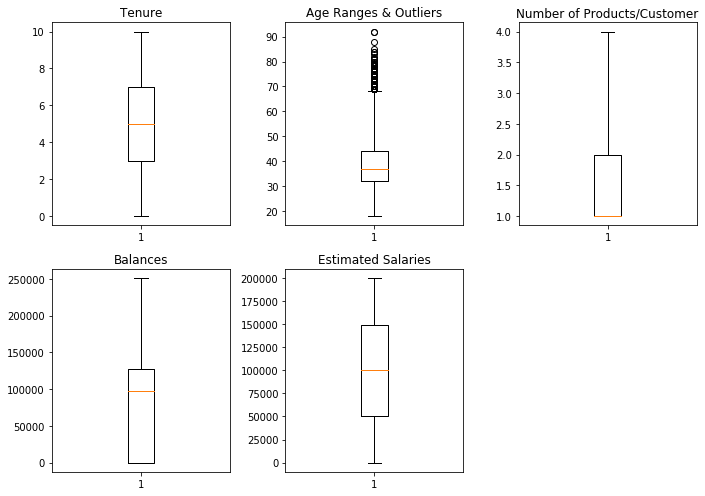

In [17]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
plt.boxplot(all_variables_df['Tenure'], whis=1.5)
plt.title('Tenure')

plt.subplot(2, 3, 2)
plt.boxplot(all_variables_df['Age'], whis=2.0)
plt.title('Age Ranges & Outliers')

plt.subplot(2, 3, 3)
plt.boxplot(all_variables_df['NumOfProducts'], whis=2.0)
plt.title('Number of Products/Customer')

plt.subplot(2, 3, 4)
plt.boxplot(all_variables_df['Balance'], whis=2.0)
plt.title('Balances')

plt.subplot(2, 3, 5)
plt.boxplot(all_variables_df['EstimatedSalary'], whis=2.0)
plt.title('Estimated Salaries')

plt.tight_layout()
plt.show()

After looking at the box and whiskers plots, my observations are:

- I'm surprised that the longest tenured customer has only had an account for 10 years, especially since the average customer is almost 39. Plus, my understanding was that members of that generation have more brand loyalty than younger generations. 


- There are quite a few outliers in the "age" variable, that could mean that this is an established, legacy bank.


- It's unsual that most of the customers only have one product with the bank - and that the bank only offers four products. In my experience, banks typically offer more products than that. I'll be curious to see if customers with lower churn use more than one of the product offerings.


- I'm surprised that there aren't outliers in the "Balances" and "Estimated Salaries" charts. And it's interesting that they have similar median values (roughly 100,000  moneys) and maximum values (about 250,000 and 200,000 moneys, respectively).

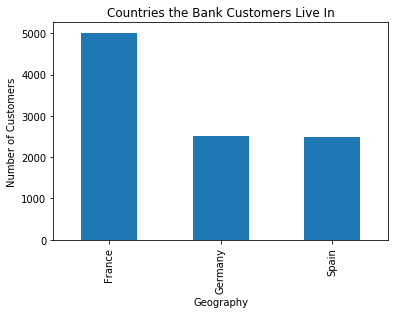

In [18]:
df = dropped_col_df.groupby(['Geography'])['CreditScore'].count()
plt.ylabel('Number of Customers')
plt.title('Countries the Bank Customers Live In')

df.plot.bar()

Since there are three countries in the dataset, this data may be from a small bank (comparatively speaking) that only operates in Europe.

_Checking for Missing Values_

In some cases, missing values can cause code to run into errors, so I'd like to see if any of the variables are missing information. 

If they are, I'll decide on a way to fill in the missing information.

In [19]:
(all_variables_df.isnull().sum()*100) / all_variables_df.isnull().count()

EstimatedSalary      0.0
Exited               0.0
Geography_France     0.0
Geography_Germany    0.0
Geography_Spain      0.0
CustomerId           0.0
CreditScore          0.0
Gender               0.0
Age                  0.0
Tenure               0.0
Balance              0.0
NumOfProducts        0.0
HasCrCard            0.0
IsActiveMember       0.0
dtype: float64

None of the values are missing, which is great!

_Feature Engineering_

The dataframe has a variable for credit scores, but the scores are raw numbers and aren't grouped clearly. 

Grouping customers by the quality of their credit score, such as "very poor", "fair", "good" and so on, would make it easier to see patterns, so I'll use feature engineering to make a new variable called "CreditScoreRank."

Please note that I used information from [Experian](https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/), which is a consumer credit reporting company, to sort credit scores into these categories: 

- 350-579, very poor.
- 580-699, fair.
- 700-739, good.
- 740-799, very good.
- 800-850, exceptional.

In [20]:
feature_engineered_df = all_variables_df.copy()

feature_engineered_df['CreditScoreRank'] = all_variables_df['CreditScore']

In [21]:
feature_engineered_df['CreditScoreRank'] = pd.cut(all_variables_df['CreditScore'], [0, 579, 699, 739, 799, 850], 
                                                  labels=[1, 2, 3, 4, 5])

I'll compare the non-transformed 'CreditScoreRank' values with the transformed values to make sure the feature engineering worked correctly.

In [22]:
all_variables_df['CreditScore'].head(10)

0    619
1    608
2    502
3    699
4    850
5    645
6    822
7    376
8    501
9    684
Name: CreditScore, dtype: int64

In [23]:
feature_engineered_df['CreditScoreRank'].head(10)

0    2
1    2
2    1
3    2
4    5
5    2
6    5
7    1
8    1
9    2
Name: CreditScoreRank, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

### 3. Unsupervised Learning Models

Before running the supervised learning models, a few more steps need to be done, including defining the feature set, normalizing the data and reducing the data to two components.

_Define the Feature Set_

In [24]:
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 0 to 10001
Data columns (total 15 columns):
EstimatedSalary      10002 non-null float64
Exited               10002 non-null int64
Geography_France     10002 non-null uint8
Geography_Germany    10002 non-null uint8
Geography_Spain      10002 non-null uint8
CustomerId           10002 non-null int64
CreditScore          10002 non-null int64
Gender               10002 non-null uint8
Age                  10002 non-null int64
Tenure               10002 non-null int64
Balance              10002 non-null float64
NumOfProducts        10002 non-null int64
HasCrCard            10002 non-null int64
IsActiveMember       10002 non-null int64
CreditScoreRank      10002 non-null category
dtypes: category(1), float64(2), int64(8), uint8(4)
memory usage: 908.6 KB


In [25]:
X = feature_engineered_df.iloc[:, :14]
Y = feature_engineered_df.iloc[:, 14]

_Normalize the Data_

In [26]:
X_norm = normalize(X)

_Reduce the Data to Two Components_

In [27]:
X_pca = PCA(2).fit_transform(X_norm)

_Running the Models_

With the intial steps taken care of, I'll run these models below to see how well they perform: 

- Affinity propagation.
- Spectral clustering.
- K-means.
- Mean shift.

### 3.1 Affinity Propagation

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.11874910542535583
For n_clusters = 3 The average silhouette_score is : 0.11874910542535583
For n_clusters = 4 The average silhouette_score is : 0.11874910542535583


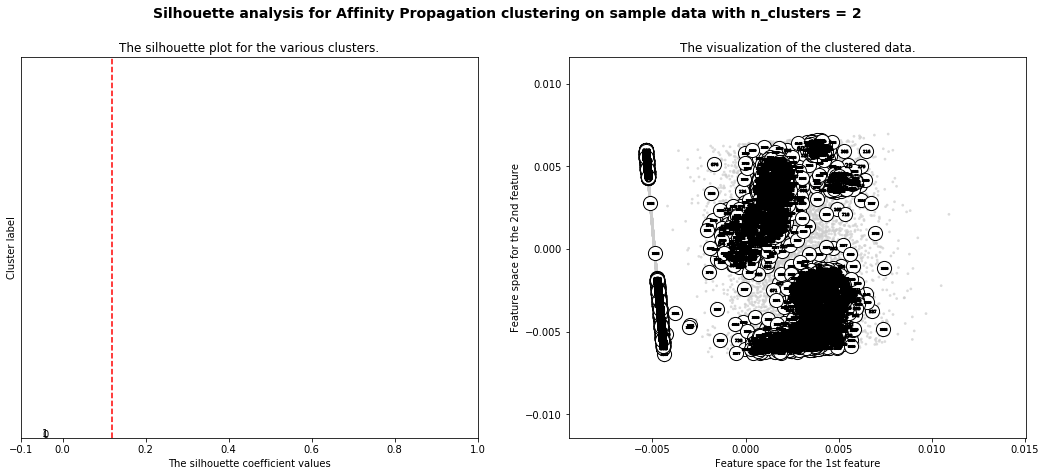

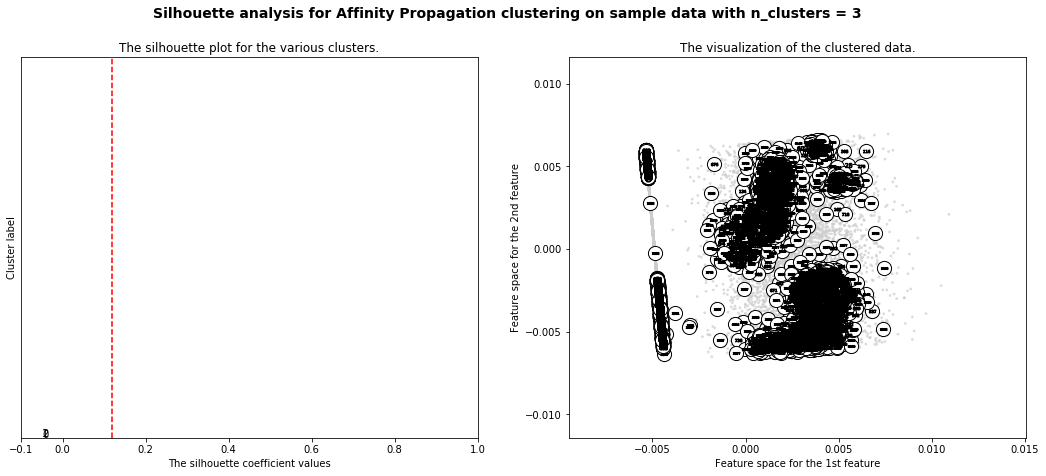

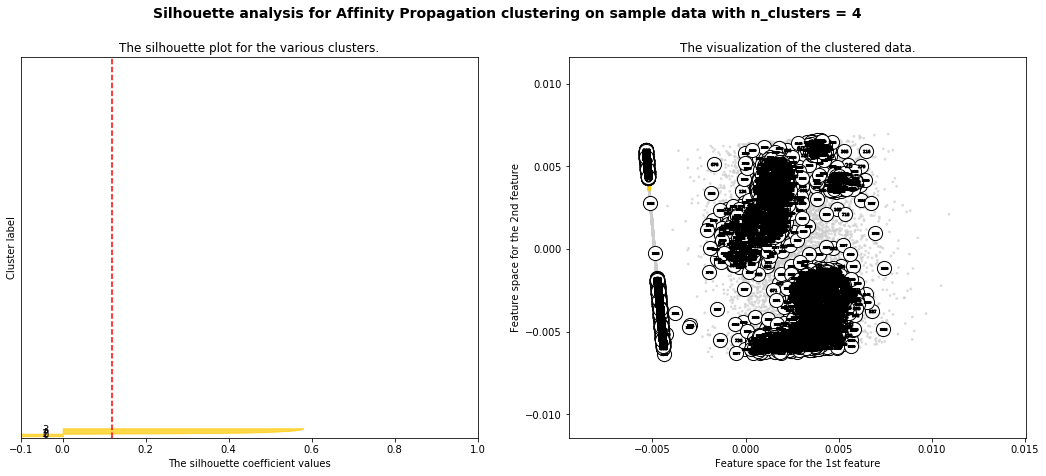

In [28]:
print(__doc__)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=30, copy=True, 
                                    preference=None, affinity='euclidean', verbose=False)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Affinity Propagation clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

_Affinity Propagation Clustering - Hyperparameter Performance Comparisons_

Model One: AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.05775644107080975
- For n_clusters = 3 The average silhouette_score is: 0.05775644107080975
- For n_clusters = 4 The average silhouette_score is: 0.05775644107080975

Model Two: AffinityPropagation(damping=0.5, max_iter=100, convergence_iter=30, copy=True, preference=None, affinity='euclidean', verbose=False)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.19801689328666458
- For n_clusters = 3 The average silhouette_score is: 0.19801689328666458
- For n_clusters = 4 The average silhouette_score is: 0.19801689328666458

Model Three: AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=30, copy=True, preference=None, affinity='euclidean', verbose=False)

Silhouette Analysis:
- For n_clusters = 2 The average silhouette_score is: 0.11874910542535583
- For n_clusters = 3 The average silhouette_score is: 0.11874910542535583
- For n_clusters = 4 The average silhouette_score is: 0.11874910542535583

### 3.2 Spectral Clustering

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4638561441345767
For n_clusters = 3 The average silhouette_score is : 0.47768914439635224
For n_clusters = 4 The average silhouette_score is : 0.23870590399975608


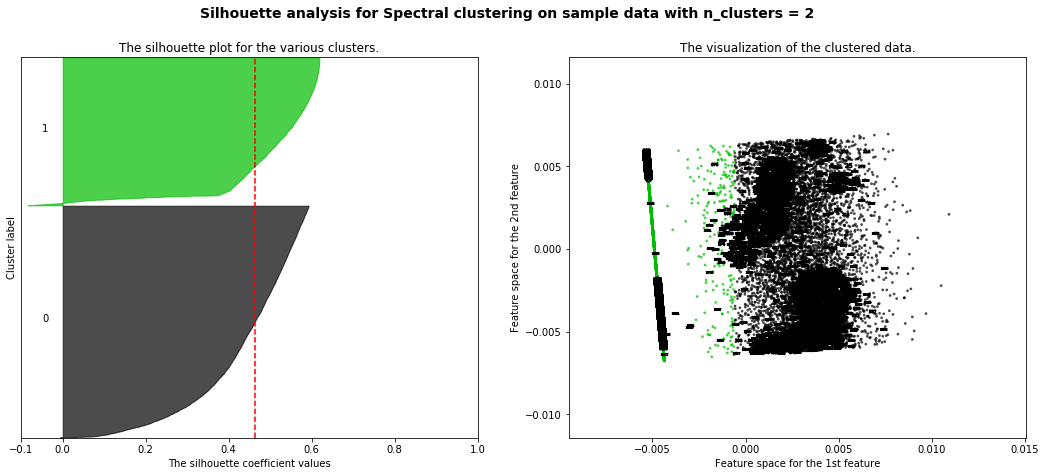

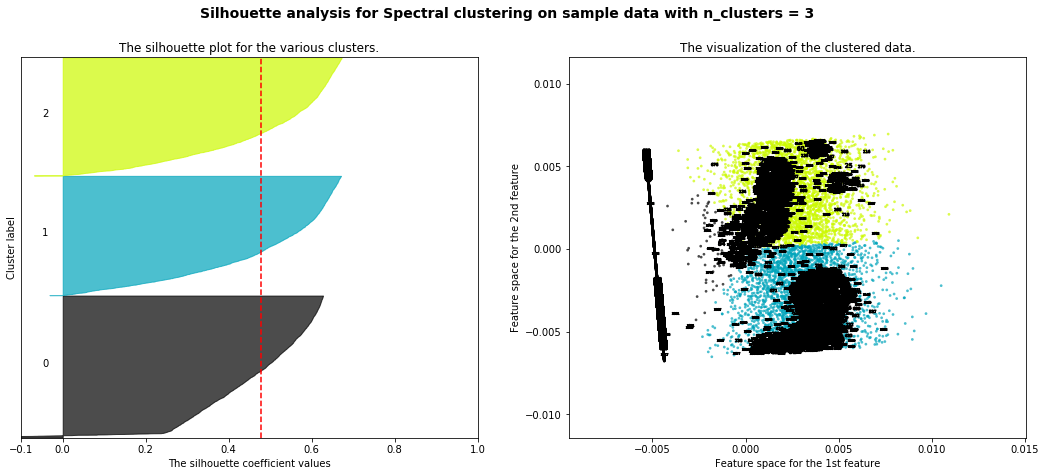

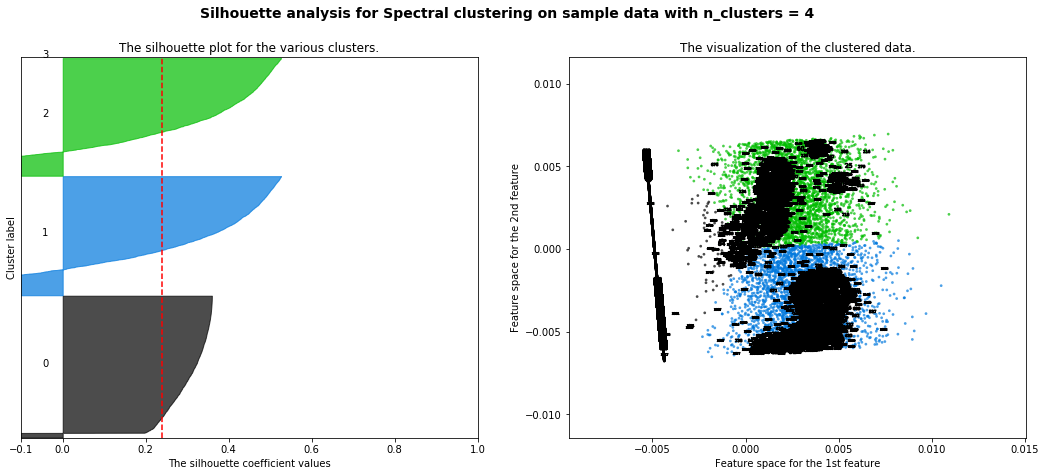

In [29]:
print(__doc__)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, n_init=20, gamma=1.0, 
                                   n_neighbors=10, eigen_tol=0.0, assign_labels='discretize', degree=3, coef0=1, 
                                   kernel_params=None, n_jobs=None)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Spectral clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

_Spectral Clustering - Hyperparameter Performance Comparisons_

Model One: SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.4638561441345765
- For n_clusters = 3 The average silhouette_score is: 0.4776891443963519
- For n_clusters = 4 The average silhouette_score is: 0.23870144117093695

Model Two: SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, n_init=20, gamma=1.0, n_neighbors=10, eigen_tol=0.0, assign_labels='discretize', degree=3, coef0=1, kernel_params=None, n_jobs=None)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.4638561441345767
- For n_clusters = 3 The average silhouette_score is: 0.47768914439635224
- For n_clusters = 4 The average silhouette_score is: 0.23870590399975608

Model Three: SpectralClustering(n_clusters=n_clusters, eigen_solver=None, random_state=None, n_init=10, gamma=1.0, n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=int)

Silhouette Analysis:
- For n_clusters = 2 The average silhouette_score is: 0.46720897603562006
- For n_clusters = 3 The average silhouette_score is: 0.4780706676475085
- For n_clusters = 4 The average silhouette_score is: 0.23883634738439857

### 3.3 K-Means

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4673705607569811
For n_clusters = 3 The average silhouette_score is : 0.47822451471311495
For n_clusters = 4 The average silhouette_score is : 0.50833662672119


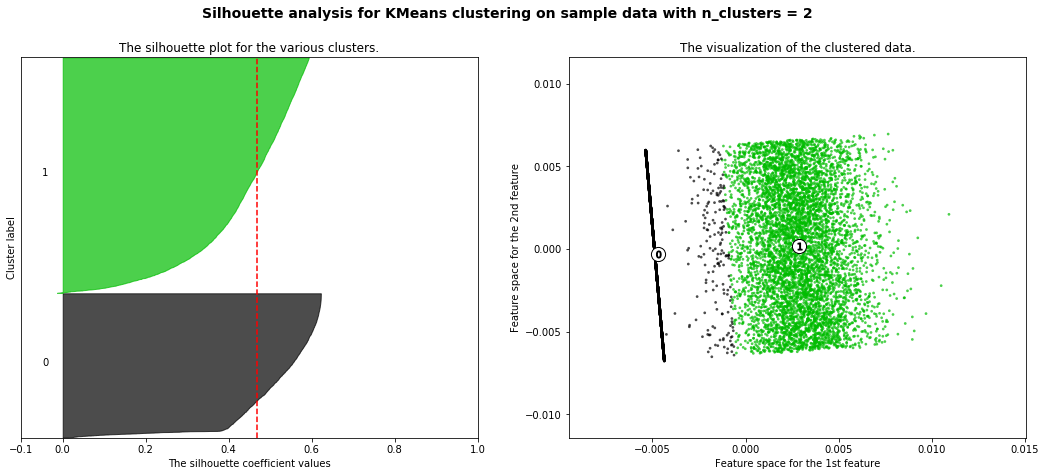

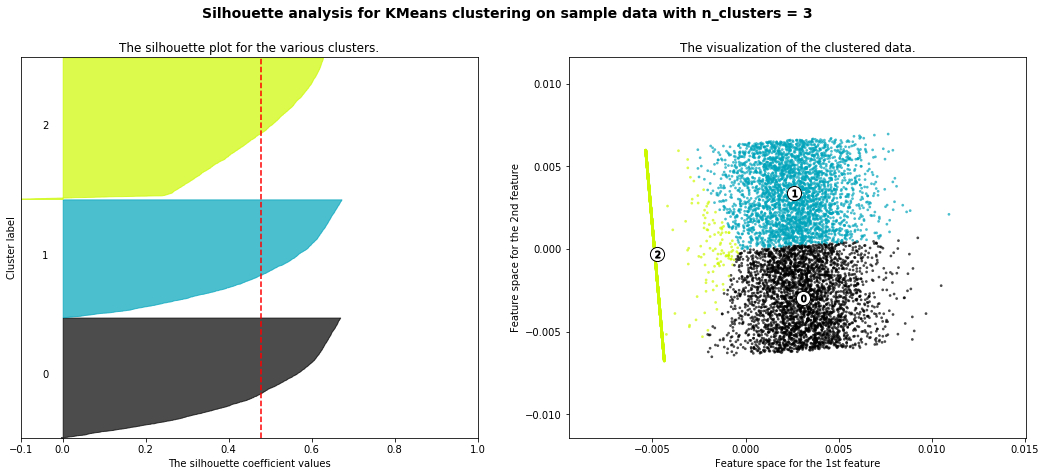

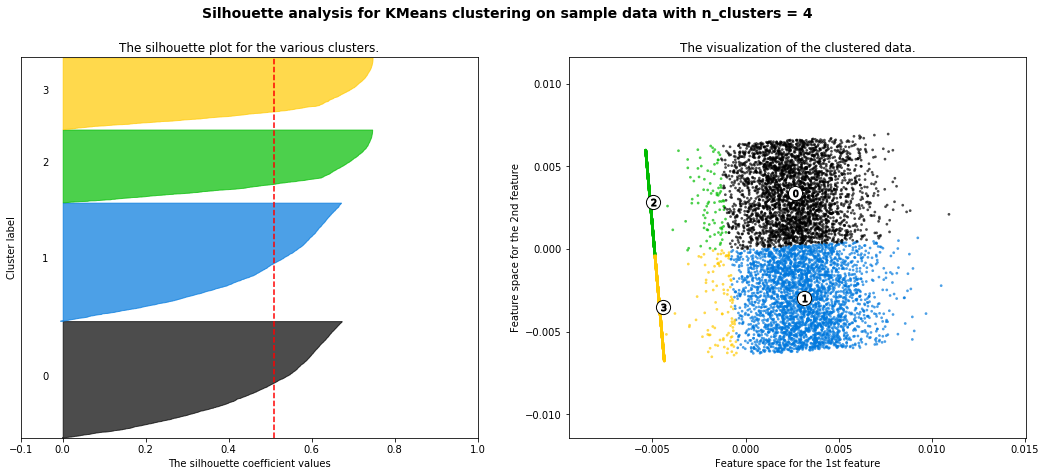

In [30]:
print(__doc__)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=50, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

_KMeans Clustering - Hyperparameter Performance Comparisons_

Model One: KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=100, random_state=20)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.46737056075698075
- For n_clusters = 3 The average silhouette_score is: 0.4782235321206207
- For n_clusters = 4 The average silhouette_score is: 0.5083548977172799

Model Two: KMeans(n_clusters=n_clusters, init='k-means++', n_init=40, max_iter=200, random_state=40)

Silhouette Analysis: 

- For n_clusters = 2 The average silhouette_score is: 0.46737056075698075
- For n_clusters = 3 The average silhouette_score is: 0.47822451471311467
- For n_clusters = 4 The average silhouette_score is: 0.5083366267211897

Model Three: KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=50, random_state=10)

Silhouette Analysis:
- For n_clusters = 2 The average silhouette_score is: 0.4673705607569811
- For n_clusters = 3 The average silhouette_score is: 0.47822451471311495
- For n_clusters = 4 The average silhouette_score is: 0.50833662672119

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4673705607569811
For n_clusters = 3 The average silhouette_score is : 0.4782257281771422
For n_clusters = 4 The average silhouette_score is : 0.5083548977172802


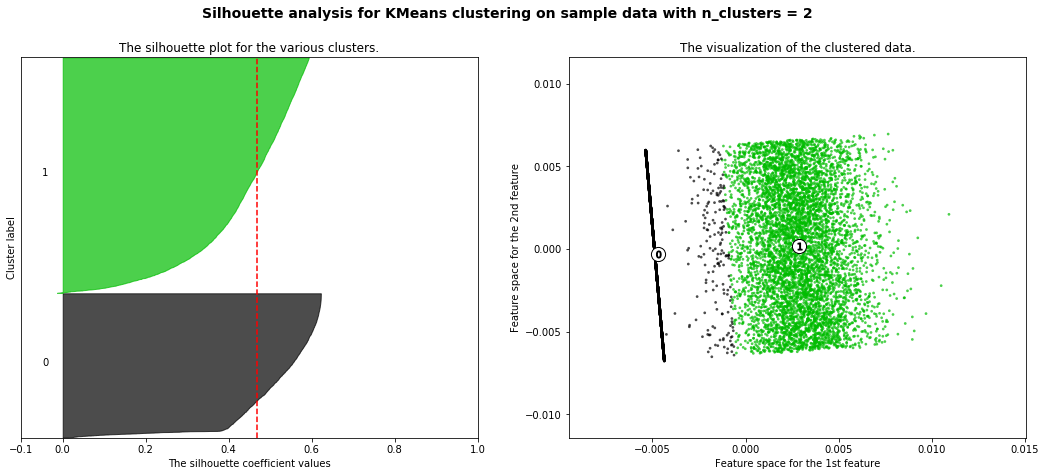

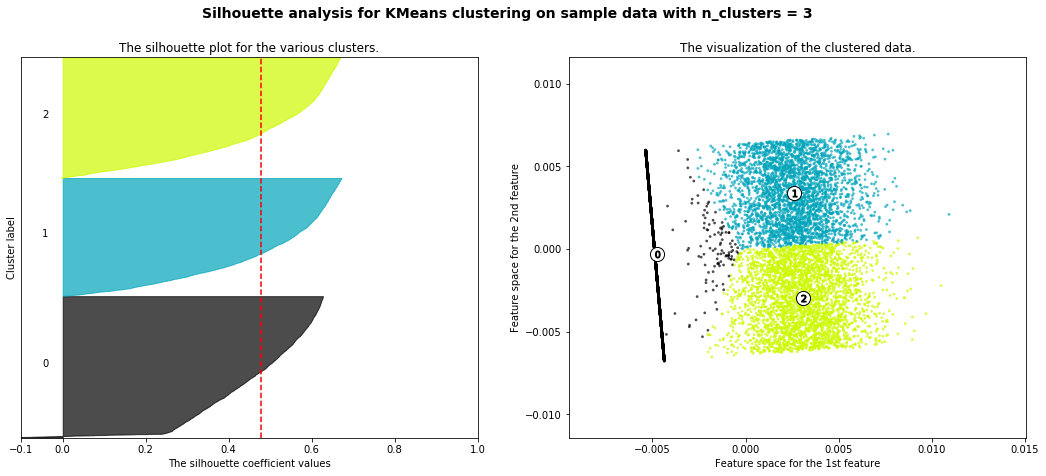

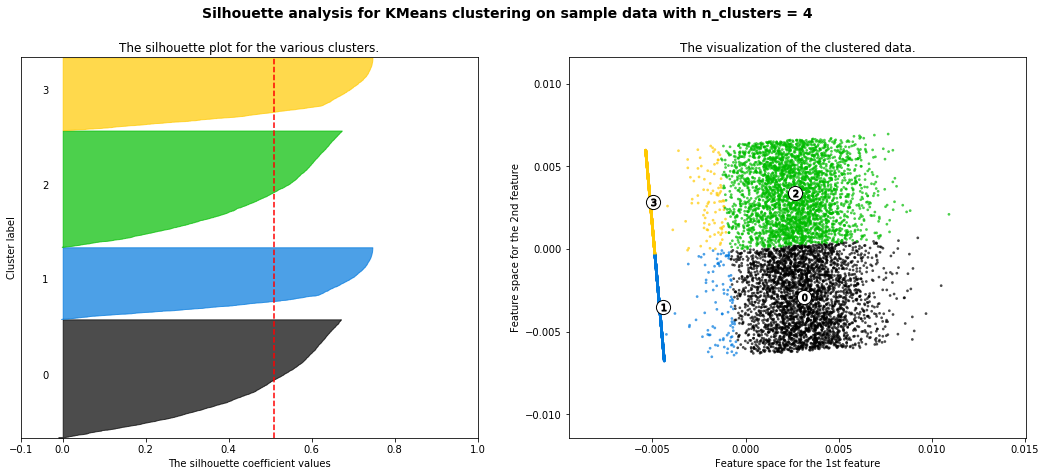

In [31]:
print(__doc__)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=50, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


_KMeans Clustering - Hyperparameter Performance Comparisons_

Model One: KMeans(n_clusters=n_clusters, init='random', n_init=20, max_iter=100, random_state=20)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.46737056075698075
- For n_clusters = 3 The average silhouette_score is: 0.47822812838404
- For n_clusters = 4 The average silhouette_score is: 0.5083366267211897

Model Two: KMeans(n_clusters=n_clusters, init='random', n_init=40, max_iter=200, random_state=40)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.46737056075698075
- For n_clusters = 3 The average silhouette_score is: 0.4782310022927737
- For n_clusters = 4 The average silhouette_score is: 0.5083548977172799

Model Three: KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=50, random_state=10)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.4673705607569811
- For n_clusters = 3 The average silhouette_score is: 0.4782257281771422
- For n_clusters = 4 The average silhouette_score is: 0.5083548977172802

### 3.4 Mean Shift

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.33618034486900233
For n_clusters = 3 The average silhouette_score is : 0.33618034486900233
For n_clusters = 4 The average silhouette_score is : 0.33618034486900233


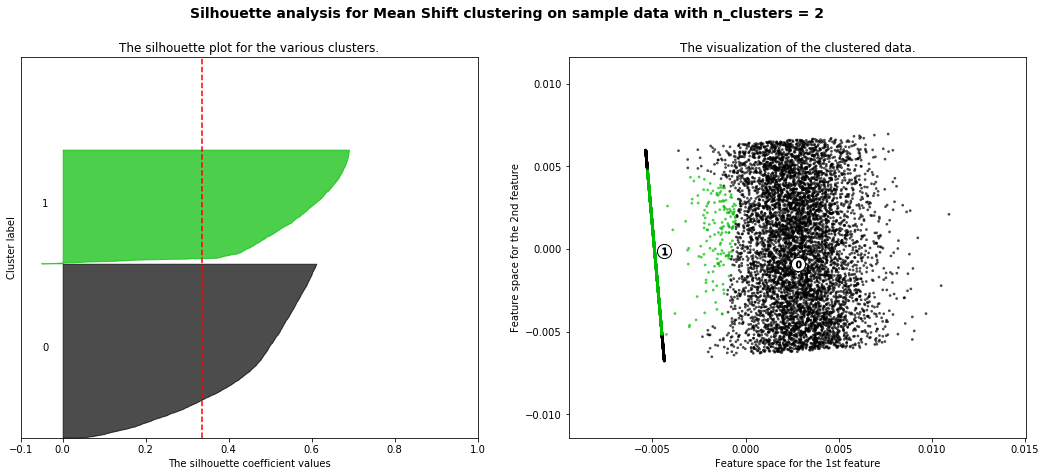

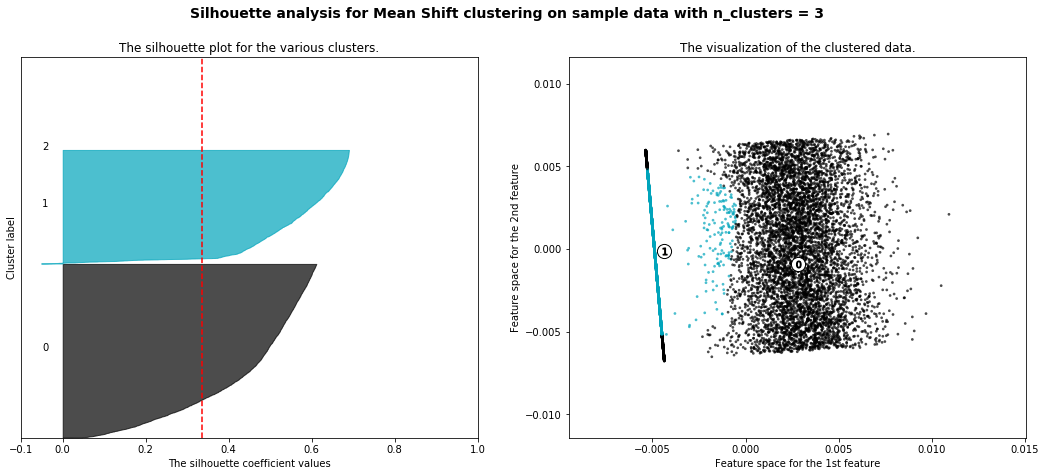

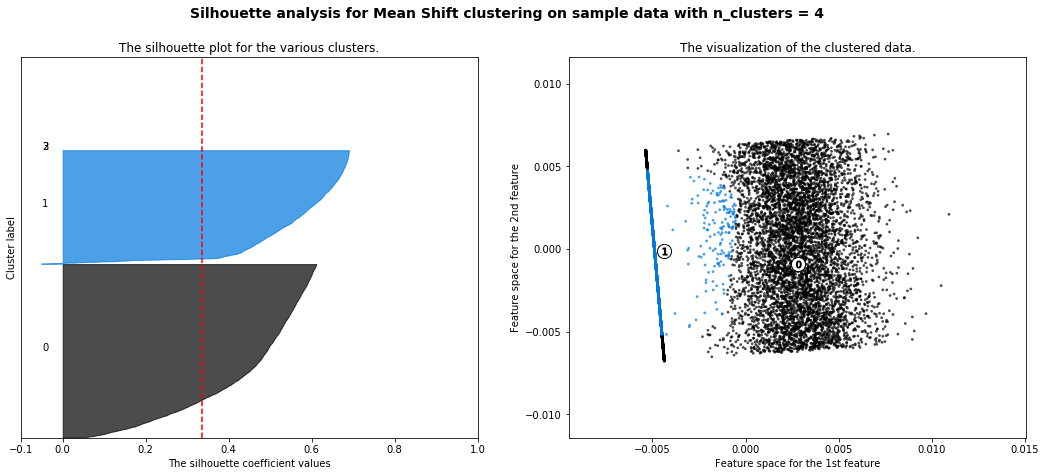

In [32]:
print(__doc__)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MeanShift(bandwidth=None, seeds=None, bin_seeding=True, min_bin_freq=1, cluster_all=False, n_jobs=None)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Mean Shift clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

_Mean Shift Clustering - Hyperparameter Performance Comparisons_

Model One: MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None)

Silhouette Analysis: 
- For n_clusters = 2 The average silhouette_score is: 0.4663929091087197
- For n_clusters = 3 The average silhouette_score is: 0.4663929091087197
- For n_clusters = 4 The average silhouette_score is: 0.4663929091087197

Model Two: MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=False, n_jobs=None)

Silhouette Analysis:
- For n_clusters = 2 The average silhouette_score is: 0.309196638879824
- For n_clusters = 3 The average silhouette_score is: 0.309196638879824
- For n_clusters = 4 The average silhouette_score is: 0.309196638879824

Model Three: MeanShift(bandwidth=None, seeds=None, bin_seeding=True, min_bin_freq=1, cluster_all=False, n_jobs=None)

Silhouette Analysis:
- For n_clusters = 2 The average silhouette_score is: 0.33618034486900233
- For n_clusters = 3 The average silhouette_score is: 0.33618034486900233
- For n_clusters = 4 The average silhouette_score is: 0.33618034486900233

### 4. The Strongest Performing Model

Of the models (affinity propagation, spectral clustering, k-means and mean shift) k-means had the highest sillouhette score at 0.5083548977172802.

While several hyperparameter options were tested, these hyperparameters both gave the score listed above: 

- KMeans(n_clusters=4, init='random', n_init=40, max_iter=200, random_state=40)
- KMeans(n_clusters=4, init='random', n_init=10, max_iter=50, random_state=10)

For the cluster analysis in the next section, I'll use the second hyperparameter option because it's less computationally intensive.

### 4. Analyzing Cluster Patterns

I'll make a new variable called "cluster", add it to my dataframe and analyze the patterns that are there.

In [33]:
cluster = KMeans(n_clusters=4, init='random', n_init=10, max_iter=50, random_state=10).fit_predict(X_pca)

In [34]:
feature_engineered_df['Cluster'] = cluster

In [35]:
feature_engineered_df.groupby('Cluster').describe()

EstimatedSalary                                                                                          Exited                                              Geography_France                                              Geography_Germany                                              Geography_Spain                                              CustomerId                                                                                           CreditScore                                                              Gender                                                  Age                                                      Tenure                                               Balance                                                                                        NumOfProducts                                              HasCrCard                                              IsActiveMember                                             
                  count           mean           std       min          25%         50%          75%        max   count      mean       std  min  25%  50%  75%  max            count      mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max           count      mean       std  min  25%  50%  75%  max      count          mean           std         min          25%         50%          75%         max       count        mean        std    min     25%    50%     75%    max   count      mean       std  min  25%  50%  75%  max   count       mean        std   min   25%   50%   75%   max   count      mean       std  min  25%  50%  75%   max   count           mean           std       min          25%        50%          75%        max         count      mean       std  min  25%  50%  75%  max     count      mean       std  min  25%  50%  75%  max          count      mean       std  min  25%  50%  75%  max
Cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
0                3120.0  149893.272657  29049.447129  99818.31  124677.8850  149375.365  175296.1075  199970.74  3120.0  0.243269  0.429125  0.0  0.0  0.0  0.0  1.0           3120.0  0.401603  0.490301  0.0  0.0  0.0  1.0  1.0            3120.0  0.397756  0.489513  0.0  0.0  0.0  1.0  1.0          3120.0  0.200641  0.400544  0.0  0.0  0.0  0.0  1.0     3120.0  1.569061e+07  70913.869661  15566156.0  15630243.25  15689555.5  15752180.75  15815656.0      3120.0  651.026923  97.540669  350.0  583.00  652.0  719.00  850.0  3120.0  0.538141  0.498623  0.0  0.0  1.0  1.0  1.0  3120.0  38.990385  10.397451  18.0  32.0  37.0  44.0  92.0  3120.0  5.005449  2.930471  0.0  2.0  5.0  8.0  10.0  3120.0  121969.534997  27925.905083  62055.17  102360.8325  120908.39  139980.9650  238387.56        3120.0  1.402564  0.590178  1.0  1.0  1.0  2.0  4.0    3120.0  0.694872  0.460536  0.0  0.0  1.0  1.0  1.0         3120.0  0.513462  0.499899  0.0  0.0  1.0  1.0  1.0
1                1894.0  149184.322883  29277.932374  98802.76  124010.3025  148991.310  174811.7125  199992.48  1894.0  0.149947  0.357114  0.0  0.0  0.0  0.0  1.0    

### 4.1 Analyzing the Clusters Individually

In [36]:
cluster_one_df = feature_engineered_df.groupby('Cluster').describe().loc[0]

In [37]:
cluster_two_df = feature_engineered_df.groupby('Cluster').describe().loc[1]

In [38]:
cluster_three_df = feature_engineered_df.groupby('Cluster').describe().loc[2]

In [39]:
cluster_four_df = feature_engineered_df.groupby('Cluster').describe().loc[3]

### 4.1.1 Finding the Maximum, Minimum and Median Values for Each Cluster

_Cluster One_

In [40]:
cluster_one_df['EstimatedSalary']

count      3120.000000
mean     149893.272657
std       29049.447129
min       99818.310000
25%      124677.885000
50%      149375.365000
75%      175296.107500
max      199970.740000
Name: 0, dtype: float64

In [41]:
cluster_one_df['EstimatedSalary'].median()

137026.625

_Cluster Two_

In [42]:
cluster_two_df['EstimatedSalary']

count      1894.000000
mean     149184.322883
std       29277.932374
min       98802.760000
25%      124010.302500
50%      148991.310000
75%      174811.712500
max      199992.480000
Name: 1, dtype: float64

In [43]:
cluster_two_df['EstimatedSalary'].median()

136500.80625

_Cluster Three_

In [44]:
cluster_three_df['EstimatedSalary']

count      3074.000000
mean      50606.941444
std       28535.486190
min          11.580000
25%       26190.025000
50%       51106.350000
75%       75244.567500
max      100816.290000
Name: 2, dtype: float64

In [45]:
cluster_three_df['EstimatedSalary'].median()

39571.213817236734

_Cluster Four_

In [46]:
cluster_four_df['EstimatedSalary']

count     1914.000000
mean     49720.163229
std      29269.441209
min         90.070000
25%      24737.910000
50%      50048.835000
75%      75915.157500
max      99828.450000
Name: 3, dtype: float64

In [47]:
cluster_four_df['EstimatedSalary'].median()

39494.80221877586

### 4.1.2 Finding the Percentage of Customers that have Left the Bank

I'd like to see how man customers have left the bank and I know that many of the variables in the dataframe are booleans (1 being true), so I should be able to figure out how many customers left by finding the sum of the "1" values in the "Exit" variable.

The formula for mean is the sum of all the data points (which is our unknown variable) divided by the number of data points (3120). Since we know the mean (0.24), we can plug that into the formula to solve for X (or the sum of all the data), then multiply it by 100 to express X as a percentage.

That math looks like:

0.24 = X / 3120 --> 0.24 * 3120 = X --> 749 = X

749/3120 = 0.24 --> 0.24 * 100 = 24

To make it easier to do those math equations for all the clusters, I'll define a function that can solve for X and return it as a percentage. 

(And because multiple other variables have boolean datapoints, I can use the function to look at other variables the same way.)

In [48]:
def find_x(num1, num2):
    multiplier = num1 * num2
    x_as_percentage = (multiplier / num2) * 100
    return print(x_as_percentage, '%')

_Cluster One_

In [49]:
find_x(0.24, 3120)

24.0 %


_Cluster Two_

In [50]:
find_x(0.14, 1912)

14.000000000000002 %


_Cluster Three_

In [51]:
find_x(0.24, 3070)

24.0 %


_Cluster Four_

In [52]:
find_x(0.15, 1891)

15.0 %


### 4.1.3 Where the Customers Live

I'll pull data from the descriptive statistics table to see what percentage of cluster one's customers live in France, Germany and Spain, respectively.

_Cluster One_

In [53]:
# France
find_x(0.4, 3120)

# Germany
find_x(0.4, 3120)

# Spain
find_x(0.2, 3120)

40.0 %
40.0 %
20.0 %


_Cluster Two_

In [54]:
# France
find_x(0.66, 1912)

# Germany
find_x(0.01, 1912)

# Spain
find_x(0.33, 1912)

66.0 %
1.0 %
33.0 %


_Cluster Three_

In [55]:
# France
find_x(0.41, 3070)

# Germany
find_x(0.39, 3070)

# Spain
find_x(0.2, 3070)

40.99999999999999 %
38.99999999999999 %
20.0 %


_Cluster Four_

In [56]:
# France
find_x(0.66, 1891)

# Germany
find_x(0.02, 1891)

# Spain
find_x(0.32, 1891)

65.99999999999999 %
2.0 %
32.0 %


### 4.1.4 Customers' Credit Scores

_Cluster One_

In [57]:
cluster_one_df['CreditScore']

count    3120.000000
mean      651.026923
std        97.540669
min       350.000000
25%       583.000000
50%       652.000000
75%       719.000000
max       850.000000
Name: 0, dtype: float64

In [58]:
cluster_one_df['CreditScore'].median()

651.5134615384616

_Cluster Two_

In [59]:
cluster_two_df['CreditScore']

count    1894.000000
mean      648.587117
std        95.718643
min       350.000000
25%       584.000000
50%       651.000000
75%       716.000000
max       850.000000
Name: 1, dtype: float64

In [60]:
cluster_two_df['CreditScore'].median()

649.7935586061246

_Cluster Three_

In [61]:
cluster_three_df['CreditScore']

count    3074.000000
mean      651.577424
std        96.468539
min       363.000000
25%       586.000000
50%       653.000000
75%       718.000000
max       850.000000
Name: 2, dtype: float64

In [62]:
cluster_three_df['CreditScore'].median()

652.2887117761874

_Cluster Four_

In [63]:
cluster_four_df['CreditScore']

count    1914.000000
mean      650.055381
std        96.464539
min       373.000000
25%       581.250000
50%       651.000000
75%       716.750000
max       850.000000
Name: 3, dtype: float64

In [64]:
cluster_four_df['CreditScore'].median()

650.5276907001045

### 4.1.5 Percentage of Male and Female Customers in Each Cluster

In the dataset, if a customer was female, then a 0 was put down in the "Gender" variable and if the customer was male, a "1" was put down. 

Given that, I can find the number of males and females in each cluster.

_Cluster One_

In [65]:
find_x(0.54, 3120)

54.0 %


54% of the customers are male and 46% are female.

_Cluster Two_

In [66]:
find_x(0.55, 1912)

55.00000000000001 %


55% of the customers are male and 45% are female.

_Cluster Three_

In [67]:
find_x(0.56, 3070)

56.00000000000001 %


56% of the customers are male and 44% are female.

_Cluster Four_

In [68]:
find_x(0.53, 1891)

53.0 %


53% of the customers are male and 47% are female.

### 4.1.6 Customers' Ages

_Cluster One_

In [69]:
cluster_one_df['Age']

count    3120.000000
mean       38.990385
std        10.397451
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: 0, dtype: float64

In [70]:
cluster_one_df['Age'].median()

37.99519230769231

_Cluster Two_

In [71]:
cluster_two_df['Age']

count    1894.000000
mean       38.406019
std        10.562539
min        19.000000
25%        31.000000
50%        37.000000
75%        43.000000
max        85.000000
Name: 1, dtype: float64

In [72]:
cluster_two_df['Age'].median()

37.70300950369588

_Cluster Three_

In [73]:
cluster_three_df['Age']

count    3074.000000
mean       39.402082
std        10.545379
min        18.000000
25%        32.000000
50%        38.000000
75%        44.000000
max        92.000000
Name: 2, dtype: float64

In [74]:
cluster_three_df['Age'].median()

38.701040988939496

_Cluster Four_

In [75]:
cluster_four_df['Age']

count    1914.000000
mean       38.544932
std        10.435339
min        18.000000
25%        32.000000
50%        37.000000
75%        43.000000
max        88.000000
Name: 3, dtype: float64

In [76]:
cluster_four_df['Age'].median()

37.77246603970742

### 4.1.7 Customer Tenure

_Cluster One_

In [77]:
cluster_one_df['Tenure']

count    3120.000000
mean        5.005449
std         2.930471
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: 0, dtype: float64

In [78]:
cluster_one_df['Tenure'].median()

5.002724358974358

_Cluster Two_

In [79]:
cluster_two_df['Tenure']

count    1894.000000
mean        5.072862
std         2.855005
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: 1, dtype: float64

In [80]:
cluster_two_df['Tenure'].median()

5.036430834213306

_Cluster Three_

In [81]:
cluster_three_df['Tenure']

count    3074.000000
mean        4.959662
std         2.887578
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: 2, dtype: float64

In [82]:
cluster_three_df['Tenure'].median()

4.979830839297332

_Cluster Four_

In [83]:
cluster_four_df['Tenure']

count    1914.000000
mean        5.048067
std         2.873858
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: 3, dtype: float64

In [84]:
cluster_four_df['Tenure'].median()

5.024033437826541

### 4.1.8 Account Balances

_Cluster One_

In [85]:
cluster_one_df['Balance']

count      3120.000000
mean     121969.534997
std       27925.905083
min       62055.170000
25%      102360.832500
50%      120908.390000
75%      139980.965000
max      238387.560000
Name: 0, dtype: float64

In [86]:
cluster_one_df['Balance'].median()

111634.61125

_Cluster Two_

In [87]:
cluster_two_df['Balance']

count     1894.000000
mean      2681.441832
std      11658.840396
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      62732.650000
Name: 1, dtype: float64

In [88]:
cluster_two_df['Balance'].median()

947.0

_Cluster Three_

In [89]:
cluster_three_df['Balance']

count      3074.000000
mean     121936.730566
std       27847.306585
min       62052.280000
25%      102131.677500
50%      121168.540000
75%      140006.632500
max      250898.090000
Name: 2, dtype: float64

In [90]:
cluster_three_df['Balance'].median()

111650.10875

_Cluster Four_

In [91]:
cluster_four_df['Balance']

count     1914.000000
mean      2355.808229
std      10846.677462
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      62339.810000
Name: 3, dtype: float64

In [92]:
cluster_four_df['Balance'].median()

957.0

### 4.1.9 Number of Products per Customer

_Cluster One_

In [93]:
cluster_one_df['NumOfProducts']

count    3120.000000
mean        1.402564
std         0.590178
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: 0, dtype: float64

In [94]:
cluster_one_df['NumOfProducts'].median()

1.2012820512820512

_Cluster Two_

In [95]:
cluster_two_df['NumOfProducts']

count    1894.000000
mean        1.761352
std         0.507800
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: 1, dtype: float64

In [96]:
cluster_two_df['NumOfProducts'].median()

1.880675818373812

_Cluster Three_

In [97]:
cluster_three_df['NumOfProducts']

count    3074.000000
mean        1.367925
std         0.561504
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: 2, dtype: float64

In [98]:
cluster_three_df['NumOfProducts'].median()

1.1839622641509435

_Cluster Four_

In [99]:
cluster_four_df['NumOfProducts']

count    1914.000000
mean        1.770637
std         0.509353
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: 3, dtype: float64

In [100]:
cluster_four_df['NumOfProducts'].median()

1.8853187042842214

### 4.1.10 Credit Card Ownership

_Cluster One_

In [101]:
find_x(0.69, 3120)

69.0 %


_Cluster Two_

In [102]:
find_x(0.73, 1912)

73.0 %


_Cluster Three_

In [103]:
find_x(0.7, 3070)

70.0 %


_Cluster Four_

In [104]:
find_x(0.71, 1891)

71.0 %


### 4.1.11 Status as an Active Member

_Cluster One_

In [105]:
find_x(0.51, 3120)

51.0 %


_Cluster Two_

In [106]:
find_x(0.53, 1912)

53.0 %


_Cluster Three_

In [107]:
find_x(0.51, 3070)

51.0 %


_Cluster Four_

In [108]:
find_x(0.51, 1891)

51.0 %


### 4.2 Quantiative Insights from the Clusters

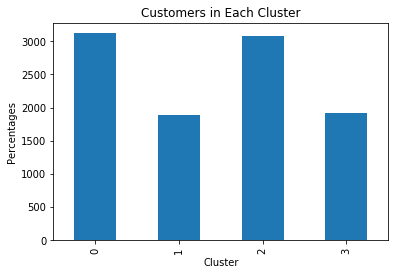

In [109]:
df = feature_engineered_df.groupby(['Cluster'])['Exited'].count()
plt.ylabel('Percentages')
plt.title('Customers in Each Cluster')

df.plot.bar()

Before going into the quantitative insights of the clusters as a whole, it'd be helpful to go over how many customers are in each of the four clusters. 

In addition to the graph above, which shows how many customers are in each cluster, here's how the bank's customers are grouped by percentage:

- Cluster one: 31%
- Cluster two: 19%
- Cluster three: 31%
- Cluster four: 19%

### 4.2.1 The Estimated Salaries of Each Cluster

In [110]:
# Since I'm going to use multiple box and whisker plots in the analysis, I'll write a function that will plot them for me.

def box_and_whiskers(variable_1, title_1, variable_2, title_2, variable_3, title_3, variable_4, title_4):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.boxplot(variable_1, whis=1.5)
    plt.title(title_1)

    plt.subplot(2, 2, 2)
    plt.boxplot(variable_2, whis=1.5)
    plt.title(title_2)

    plt.subplot(2, 2, 3)
    plt.boxplot(variable_3, whis=1.5)
    plt.title(title_3)

    plt.subplot(2, 2, 4)
    plt.boxplot(variable_4, whis=1.5)
    plt.title(title_4)

    plt.show()
    
    return

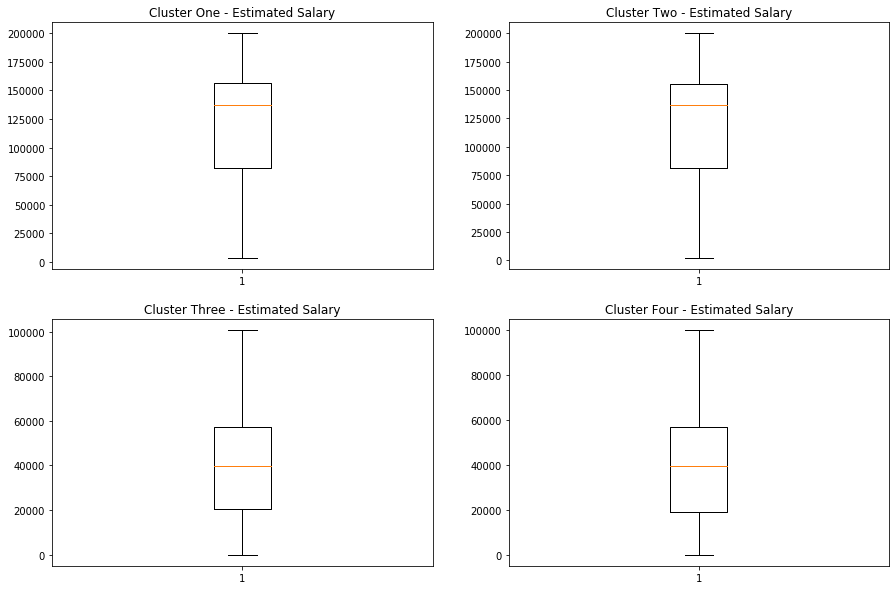

In [111]:
box_and_whiskers(cluster_one_df['EstimatedSalary'], 'Cluster One - Estimated Salary', 
                 cluster_two_df['EstimatedSalary'], 'Cluster Two - Estimated Salary', 
                 cluster_three_df['EstimatedSalary'], 'Cluster Three - Estimated Salary',
                 cluster_four_df['EstimatedSalary'], 'Cluster Four - Estimated Salary')

Based off estimated salary, there are two groups of customers in these cluster: high and low earners. 

The high earners have estimated salaries that range between 99,818 monies to almost 200,000 monies. In contrast, the low earners salaries range from a low of 11 monies and a high of roughly 100,000 monies.

### 4.2.2 The Percentage of Customers in Each Cluster that Left the Bank

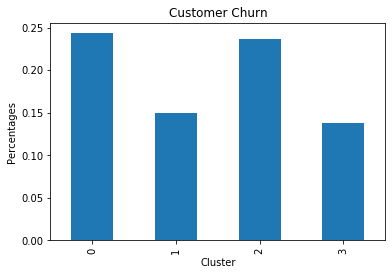

In [112]:
df = feature_engineered_df.groupby(['Cluster'])['Exited'].mean()
plt.ylabel('Percentages')
plt.title('Customer Churn')

df.plot.bar()

In clusters one and three, 24% of customers have ended their relationship with the bank.

Similarily, in cluster two, 14% of customers left the bank while 15% of customers left the bank in cluster four.

### 4.2.3 The Geographic Distribution of the Bank's Customers

In [113]:
geography_df = pd.DataFrame(np.array([[40, 40, 20], [66, 1, 33], [41, 38, 20], [66, 2, 32]]), 
                            columns=['France', 'Germany', 'Spain'])

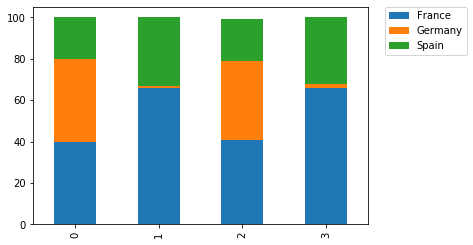

In [114]:
geography_df.plot.bar(stacked=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In clusters one and three, roughly 40% of the customers live in France, while 40% are in Germany and 20% are in Spain. 

For clusters two and four, about 66% of customers live in France, 2% are in Germany and 32% are in Spain.

An interesting thing to note is that clusters one and thee have the highest rates of churn (at 24%) and they also have the highest percentage of customers living in Germany. While that could be a coincidence, it's possible that there's a statistically significant link there. 

For instance, financial institutions in Germany may be more competitive than banks in France or Spain, so the banks customers may be leaving because they have more options to chose from.

### 4.2.4 Customers' Credit Scores

In [115]:
d = {'Cluster One': [850, 652, 350], 'Cluster Two': [850, 651, 373], 'Cluster Three': [850, 652, 363], 
     'Cluster Four': [850, 650, 350]}

credit_scores_df = pd.DataFrame(data=d)

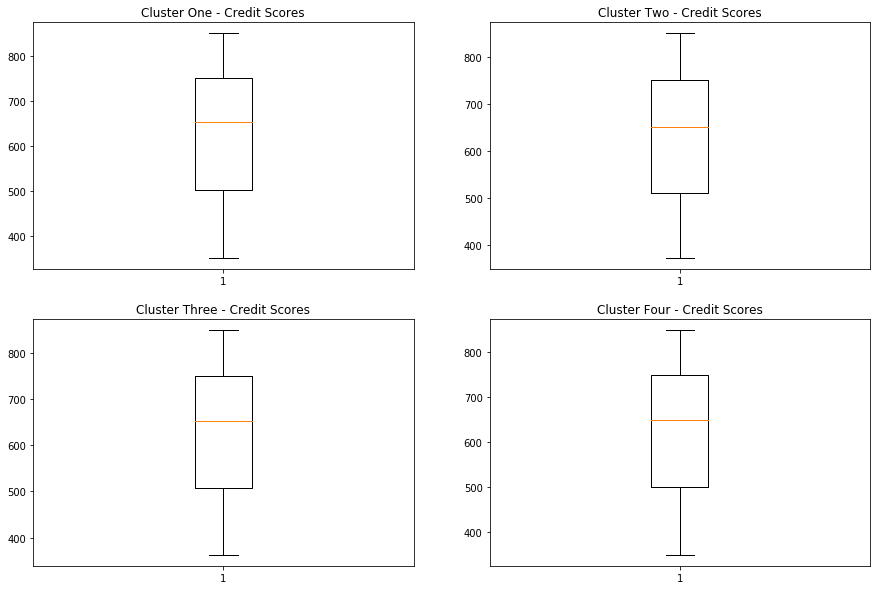

In [116]:
box_and_whiskers(credit_scores_df['Cluster One'], 'Cluster One - Credit Scores', 
                 credit_scores_df['Cluster Two'], 'Cluster Two - Credit Scores',
                 credit_scores_df['Cluster Three'], 'Cluster Three - Credit Scores', 
                 credit_scores_df['Cluster Four'], 'Cluster Four - Credit Scores')

Across all the clusters, customers' credit scores are largely the same when looking across the maximum, medium and minimum values of credit scores. 

This is helpful to know because it means that credit scores aren't likely to be a key differentiator in customer behavior.

### 4.2.5 Customer Genders

In [117]:
gender_data = {'Cluster One': [46, 54], 'Cluster Two': [45, 55], 'Cluster Three': [44, 56], 
     'Cluster Four': [47, 53]}

gender_df = pd.DataFrame(data=gender_data)

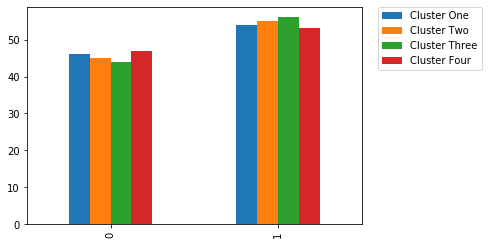

In [118]:
gender_df.plot.bar(stacked=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

The genders in each cluster are roughly evenly split (please note that "0" stands for female and "1" is for male) with each of the clusters having about a 50/50 mix of men and women.

### 4.2.6 Age Ranges Across the Clusters

In [119]:
ages = {'Cluster One': [18, 92, 38], 'Cluster Two': [19, 85, 38], 'Cluster Three': [18, 92, 39], 
     'Cluster Four': [18, 88, 38]}

ages_df = pd.DataFrame(data=ages)

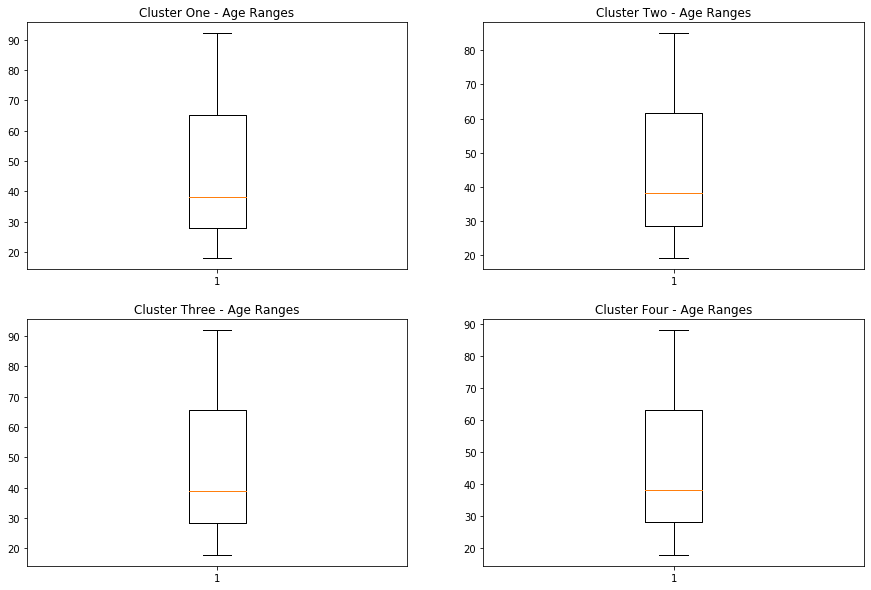

In [120]:
box_and_whiskers(ages_df['Cluster One'], 'Cluster One - Age Ranges', 
                 ages_df['Cluster Two'], 'Cluster Two - Age Ranges',
                 ages_df['Cluster Three'], 'Cluster Three - Age Ranges', 
                 ages_df['Cluster Four'], 'Cluster Four - Age Ranges')

Similar to credit scores and gender, the age ranges are extremely similar across the clusters. 

For your reference, here are the average age statistics for the clusters:

- Maximum age: 89 years of age.
- Median age: 38 years of age.
- Minimum age: 18 years of age.

### 4.2.7 Customer Tenure

In [121]:
tenure = {'Cluster One': [0, 10, 5], 'Cluster Two': [0, 10, 5], 'Cluster Three': [0, 10, 5], 
     'Cluster Four': [0, 10, 5]}

tenure_df = pd.DataFrame(data=tenure)

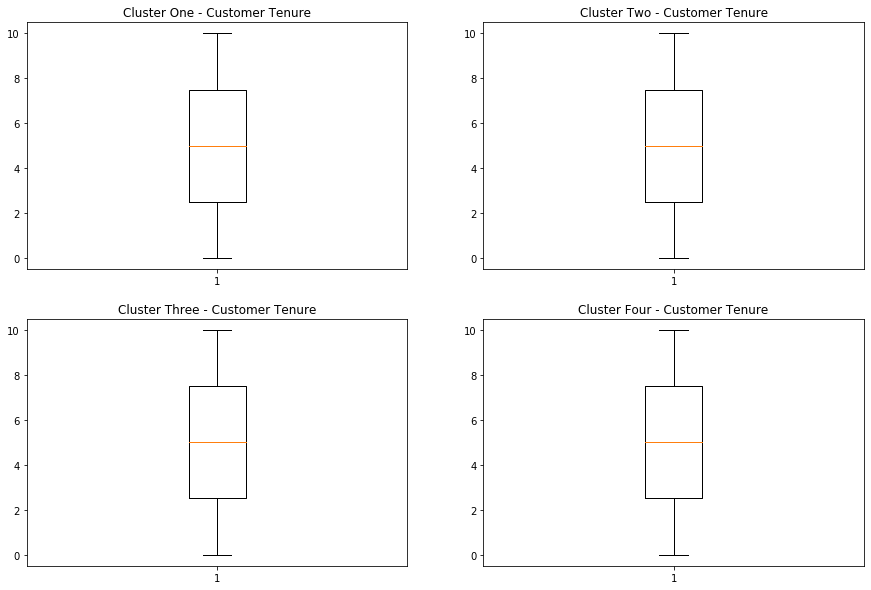

In [122]:
box_and_whiskers(tenure_df['Cluster One'], 'Cluster One - Customer Tenure', 
                 tenure_df['Cluster Two'], 'Cluster Two - Customer Tenure',
                 tenure_df['Cluster Three'], 'Cluster Three - Customer Tenure', 
                 tenure_df['Cluster Four'], 'Cluster Four - Customer Tenure')

Each cluster has nearly identical tenure information with the longest customer relationship at 10 years, the median at five years and the shortest at zero years. 

(Please note that customer tenure of zero years seems unusual and it may be possible that the customer has been with the company for less than one year.)

### 4.2.8 Balance

In [123]:
balance = {'Cluster One': [62055, 238388, 111635], 'Cluster Two': [0, 62733, 947], 'Cluster Three': [62052, 250898, 111650], 
     'Cluster Four': [0, 62340, 957]}

balance_df = pd.DataFrame(data=balance)

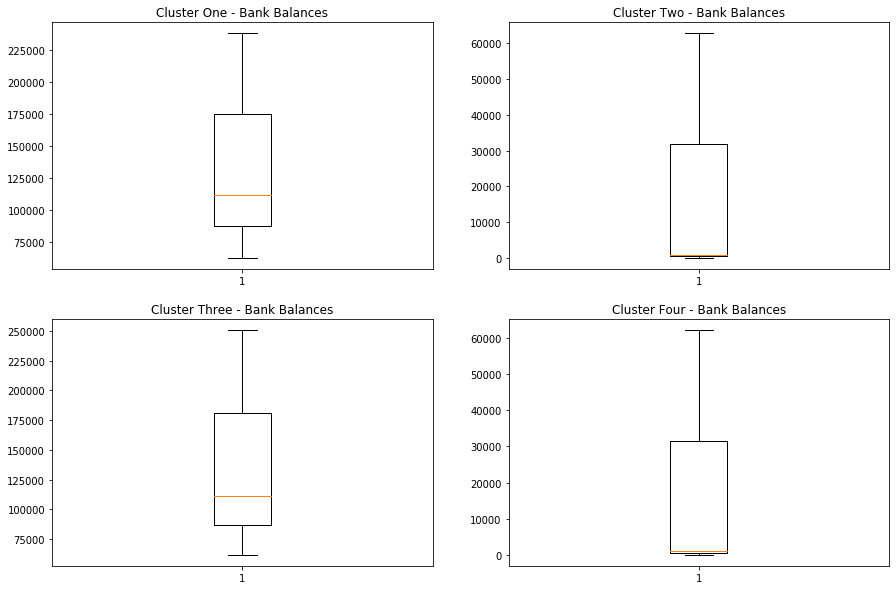

In [124]:
box_and_whiskers(balance_df['Cluster One'], 'Cluster One - Bank Balances', 
                 balance_df['Cluster Two'], 'Cluster Two - Bank Balances',
                 balance_df['Cluster Three'], 'Cluster Three - Bank Balances', 
                 balance_df['Cluster Four'], 'Cluster Four - Bank Balances')

There are two distinct groups of customers across the clusters, one group (clusters one and three) which carry high bank balances and the other (clusters two and four) which carries low balances. 

What's interesting about this is that clusters one and two are made up of customers with high estimated salaries (their salaries range from roughly 100,000-200,000 monies) while clusters three and four have customers with low estimated salaries (salaries range from 11-100,000 monies).

This shows that in both the high and low salary groups, there are two distinct groups of high and low spenders, as well as two groups of customers who save money.

### 4.2.9 Number of Products

In [125]:
products = {'Cluster One': [1, 4, 1.2], 'Cluster Two': [1, 4, 1.9], 'Cluster Three': [1, 4, 1.2], 
     'Cluster Four': [1, 4, 1.9]}

products_df = pd.DataFrame(data=products)

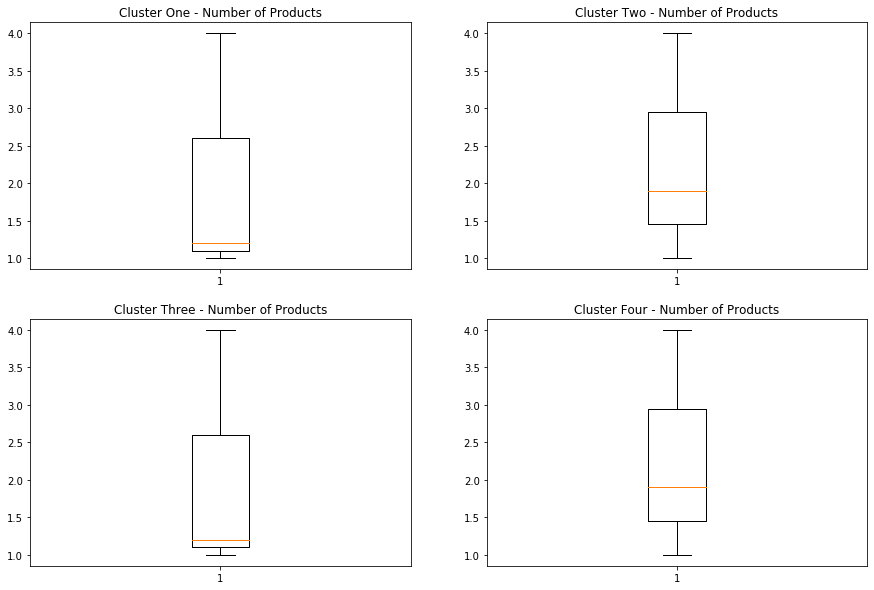

In [126]:
box_and_whiskers(products_df['Cluster One'], 'Cluster One - Number of Products', 
                 products_df['Cluster Two'], 'Cluster Two - Number of Products',
                 products_df['Cluster Three'], 'Cluster Three - Number of Products', 
                 products_df['Cluster Four'], 'Cluster Four - Number of Products')

Across the clusters, the customers use similar numbers of products, although the less wealthy customers in cluters two and four use slightly more products (a median of 1.9 vs. 1.2) than the customers that have higher bank account balances.

This could be a signal that the bank is offering products that are more valuable to the less wealthy consumers. The bank should strongly consider offering more products that are valuable to the high wealth consumers so they can get more business with that customer segment.

### 4.2.10 Customers with a Credit Card

In [127]:
credit_card_data = {'Cluster One': [31, 69], 'Cluster Two': [27, 73], 'Cluster Three': [30, 70], 
     'Cluster Four': [29, 71]}

credit_card_df = pd.DataFrame(data=credit_card_data)

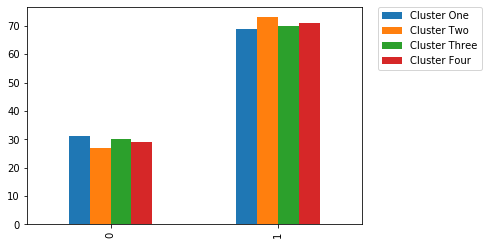

In [128]:
credit_card_df.plot.bar(stacked=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In each cluster, at least 69% of customers have a credit card.

It'd be helpful to confirm if the credit cards are owned by the bank. If the bank didn't issue the cards, the bank leadership should consider offering credit cards as a product because the majority of their customers use credit cards and it could be a good way for the bank to diversify its offerings.

### 4.2.11 Active Membership with the Bank

In [129]:
membership = {'Cluster One': [49, 51], 'Cluster Two': [47, 53], 'Cluster Three': [49, 51], 
     'Cluster Four': [49, 51]}

membership_df = pd.DataFrame(data=membership)

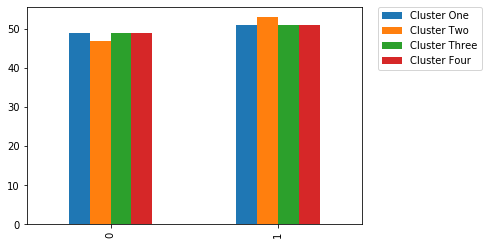

In [130]:
membership_df.plot.bar(stacked=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Each cluster has about a 50/50 split of active and unactive members.

While it's not clear what qualifies as an active member, the bank could use marketing to reach out to its non-active members and help them become more engaged.

It'd be helpful to understand how active membership is defined.

### Summary of the Cluster Analysis

After analyzing the features in each cluster, it became clear that the clusters have a number of unique traits, but there were several traits which were constant across all the groups.


_Unique Traits_

For your reference, here's what's unique about each cluster:

- Cluster One:
    - Size: 31% of customers.
    - Churn: 24% of these customers left the bank.
    - Estimated Salaries: 99,818-199,970 monies.
    - Geography: 40% of customers live in France, 40% are in Germany and 20% are in Spain.
    - Median Balance: 238,388 monies.
    - Product Usage: 1.2 products/customer.
    
        
- Cluster Two:
    - Size: 19% of customers.
    - Churn: 14% of these customers left the bank.
    - Estimated Salaries: 98,802-199,992 monies.
    - Geography: 66% of the customers live in France, 32% are in Spain and 2% live in Germany.
    - Median Balance: 62,733 monies.
    - Product Usage: 1.9 products/customer.
        
    
- Cluster Three:
    - Size: 31% of customers.
    - Churn: 24% of these customers left the bank.
    - Estimated Salaries: 11-100,816 monies.
    - Geography: 40% of customers live in France, 40% are in Germany and 20% are in Spain.
    - Median Balance: 250,898 monies.
    - Product Usage: 1.2 products/customer.
        
    
- Cluster Four:
    - Size: 19% of customers.
    - Churn: 14% of these customers left the bank.
    - Estimated Salaries: 90-99,828 monies.
    - Geography: 66% of the customers live in France, 32% are in Spain and 2% live in Germany.
    - Median Balance: 62,340 monies.
    - Product Usage: 1.9 products/customer.


_Similar Traits_

These features were nearly identical across all the clusters:
- Credit Score.
- Gender.
- Age. 
- Tenure.
- Credit Card Holder.
- Active Membership.

### Key Finding

While analyzing the cluster data, this key finding emerged: the customers that have the highest rate of churn also happen to have the largest median bank account balances, and that holds true regardless of how much the customers' salaries are.

That finding's concerning because if that trend continues, the bank will lose operating capital as its wealthiest customers leave.

And the bank may lose money to a point where it can't be competitive, meaning it could run the risk of having to close and leave the market altogether.

 ### Recommended Next Steps for the Bank

The bank should immediately focus on retaining the customers in clusters one and three. 

Then in the long-run, the bank could focus on providing financial education to its customers that are low savers so that they become high savers. The benefit of this is that if customers save more money, the bank will have more operating capital and can use that money to invest and grow.

To help the bank get started, below is a list of strategy ideas that they could use.

Short-term strategy ideas:
- Offer products that are valuable to the customers in clusters one and three. Customers in those clusters, on average, only use 1.2 products while customers in clusters two and four use 1.9 products. 
- That shows that there could be a gap between what the high-saving customers value and what the bank offers. It'd be worthwhile for the bank to make targeted products for those customers.
- Once the new product is developed, the bank could use A/B testing to market it and find an effective campaign that lowers the rate of customer churn.

Long-term strategy ideas:
- Develop educational materials on how to save money and make them available to consumers.
- Similar to the short-term strategy, A/B testing could be used to see if customers begin saving more after they receive the educational materials.